This notebook converts the raw TIMIT corpus (as represented in Huggingface `timit_asr`) into a format friendly for our modeling and analysis.

Our specific modifications to the annotation include
- mapping from TIMIT phonetic annotation into a CMUDICT phonemic annotation (available in item key `phonemic_detail`; `word_phonemic_detail` grouped by words)
- syllable annotation (available in item key `word_syllable_detail`)

Processes in this notebook
- run the conversion
- cross-check resulting lexical mappings with cmudict representation
- make sure we don't have overlapping phonemes
- visually check some waveforms and make sure they make sense
- check syllable annotations, pay attention to how syllabic consonants represented especially. there are a lot of these in the timit annotations and we are removing the evidence before syllabification

In [1]:
from collections import Counter, defaultdict
import logging
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import datasets
import transformers
from tqdm.auto import tqdm, trange

logging.basicConfig(level=logging.INFO)

In [13]:
base_dir = "/userdata/jgauthier/projects/ideal-word-representations"

# input Huggingface-format `timit_asr` dataset, with train/test split
dataset_path = "data/timit_raw"

dataset_name = "timit-no_repeats"
out_path = "data/timit_syllables"

model_name = "facebook/wav2vec2-base"

drop_timit_phones = ["h#", "pau", "epi"]
drop_cmudict_phonemes = ["[SIL]"]

In [4]:
cd {base_dir}

/userdata/jgauthier/projects/ideal-word-representations


In [5]:
sns.set_theme(style="whitegrid", font_scale=2)

In [6]:
datasets.disable_caching()

In [7]:
%load_ext autoreload
%autoreload 2

In [8]:
from src.utils import timit

In [9]:
tokenizer = transformers.Wav2Vec2Tokenizer.from_pretrained("charsiu/tokenizer_en_cmu")
feature_extractor = transformers.Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)
processor = transformers.Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/home/jgauthier/u/transformers/lib/python3.10/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:733: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(


In [10]:
raw_corpus = datasets.load_dataset(dataset_path)

In [11]:
# Tools for introspecting on raw/resulting annotations, if necessary

log_item = 25

# list(zip(raw_corpus["train"][log_item]["phonetic_detail"]["utterance"],
#          raw_corpus["train"][log_item]["phonetic_detail"]["start"],
#             raw_corpus["train"][log_item]["phonetic_detail"]["stop"]))

# list(zip(raw_corpus["train"][log_item]["word_detail"]["utterance"],
#             raw_corpus["train"][log_item]["word_detail"]["start"],
#                 raw_corpus["train"][log_item]["word_detail"]["stop"]))

# list(zip(corpus[log_item]["phonemic_detail"]["utterance"],
#          corpus[log_item]["phonemic_detail"]["start"],
#             corpus[log_item]["phonemic_detail"]["stop"]))

In [71]:
# Mark original indices in each item, then optionally filter,
# then concatenate into a single dataset
def mark_item_indices(item, idx, split=None):
    item["original_idx"] = idx
    item["original_split"] = split
    return item
raw_corpus["train"] = raw_corpus["train"].map(mark_item_indices, with_indices=True, fn_kwargs=dict(split="train"))
raw_corpus["test"] = raw_corpus["test"].map(mark_item_indices, with_indices=True, fn_kwargs=dict(split="test"))

Map:   0%|          | 0/4620 [00:00<?, ? examples/s]

Map:   0%|          | 0/1680 [00:00<?, ? examples/s]

In [72]:
corpus = datasets.concatenate_datasets([raw_corpus["train"], raw_corpus["test"]])

In [73]:
# Filters
if "no_repeats" in dataset_name:
    sentence_counts = Counter(corpus["text"])
    repeat_sentence_text = set([text for text, count in sentence_counts.items() if count > 600])

    pre_filter_length = len(corpus)
    keep_idxs = [idx for idx, text in enumerate(corpus["text"]) if text not in repeat_sentence_text]
    corpus = corpus.select(keep_idxs)
    logging.info(f"Filtered {pre_filter_length - len(corpus)} repeated sentences")

INFO:root:Filtered 1260 repeated sentences


In [74]:
logging.info(f"{len(corpus)} sentences in corpus")

INFO:root:5040 sentences in corpus


In [75]:
def mark_item_indices_2(item, idx):
    item["idx"] = idx
    return item
corpus = corpus.map(mark_item_indices_2, with_indices=True)

corpus

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx'],
    num_rows: 5040
})

In [24]:
corpus = timit.prepare_corpus(corpus, processor,
                              drop_phones=drop_timit_phones + drop_cmudict_phonemes)

corpus

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

INFO:src.utils.timit:Interpreting glottal stop as /t/ in item A sailboat may have a bone in her teeth one minute and lie becalmed the next.: n ih q ix n
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item A sailboat may have a bone in her teeth one minute and lie becalmed the next.: v ow q m ey
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item The emperor had a mean temper.: dh iy q eh m
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item Critical equipment needs proper maintenance.: w ih q m ix
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item Receiving no answer, they set the fire.: s eh q dh ix
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item Receiving no answer, they set the fire.: n ow q ae n
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item As his feet slowed, he felt ashamed of the panic and resolved to make a stand.: ey m q ax v
INFO:src.utils.timit:Interpreting glottal stop as /t/ in item A huge power outage 

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 5040
})

In [25]:
def plot_item(item_idx, ax, plot_units="phoneme", viz_rate=1000):
    item = corpus[item_idx]

    times = np.linspace(0, len(item["input_values"]) / 16000, int(len(item["input_values"]) / 16000 * viz_rate))
    # normalize to [-1, 1]
    values = np.array(item["input_values"])
    values = (values - values.min()) / (values.max() - values.min()) * 2 - 1
    # resample to viz frame rate
    values = np.interp(times, np.arange(len(values)) / 16000, values)
    ax.plot(times, values, alpha=0.2)

    # plot word and phoneme boundaries
    for i, word in enumerate(item["word_phonemic_detail"]):
        word_str = item["word_detail"]["utterance"][i]

        word_start, word_stop = word[0]["start"] / 16000, word[-1]["stop"] / 16000
        ax.axvline(word_start, color="black", linestyle="--")
        ax.text(word_start, 0.8, word_str, rotation=90, verticalalignment="bottom", alpha=0.7)

        if plot_units == "phoneme":
            for j, phoneme in enumerate(word):
                phoneme_str = phoneme["phone"]
                phoneme_start, phoneme_stop = phoneme["start"] / 16000, phoneme["stop"] / 16000

                if j > 0:
                    color = "black" if phoneme["idx_in_syllable"] == 0 else "gray"
                    ax.axvline(phoneme_start, color=color, linestyle=":", alpha=0.5)
                ax.text(phoneme_start + 0.01, -6, phoneme_str, rotation=90, verticalalignment="bottom",
                        fontdict={"size": 15})
        elif plot_units == "syllable":
            for j, syllable in enumerate(item["word_syllable_detail"][i]):
                syllable_str = " ".join(syllable["phones"])
                syllable_start, syllable_stop = syllable["start"] / 16000, syllable["stop"] / 16000

                if j > 0:
                    ax.axvline(syllable_start, color="black", linestyle=":", alpha=0.5)
                ax.text(syllable_start + 0.01, -6, syllable_str, rotation=90, verticalalignment="bottom",
                        fontdict={"size": 15})
        else:
            raise ValueError(f"Unknown plot_units: {plot_units}")

    # align at origin
    ax.set_ylim((-8, 8))

    ax.set_title(f"{item['speaker_id']}_{item['id']}: {item['text']}")
    ax.set_yticks([])
    ax.grid(False)
    ax.axis("off")

93


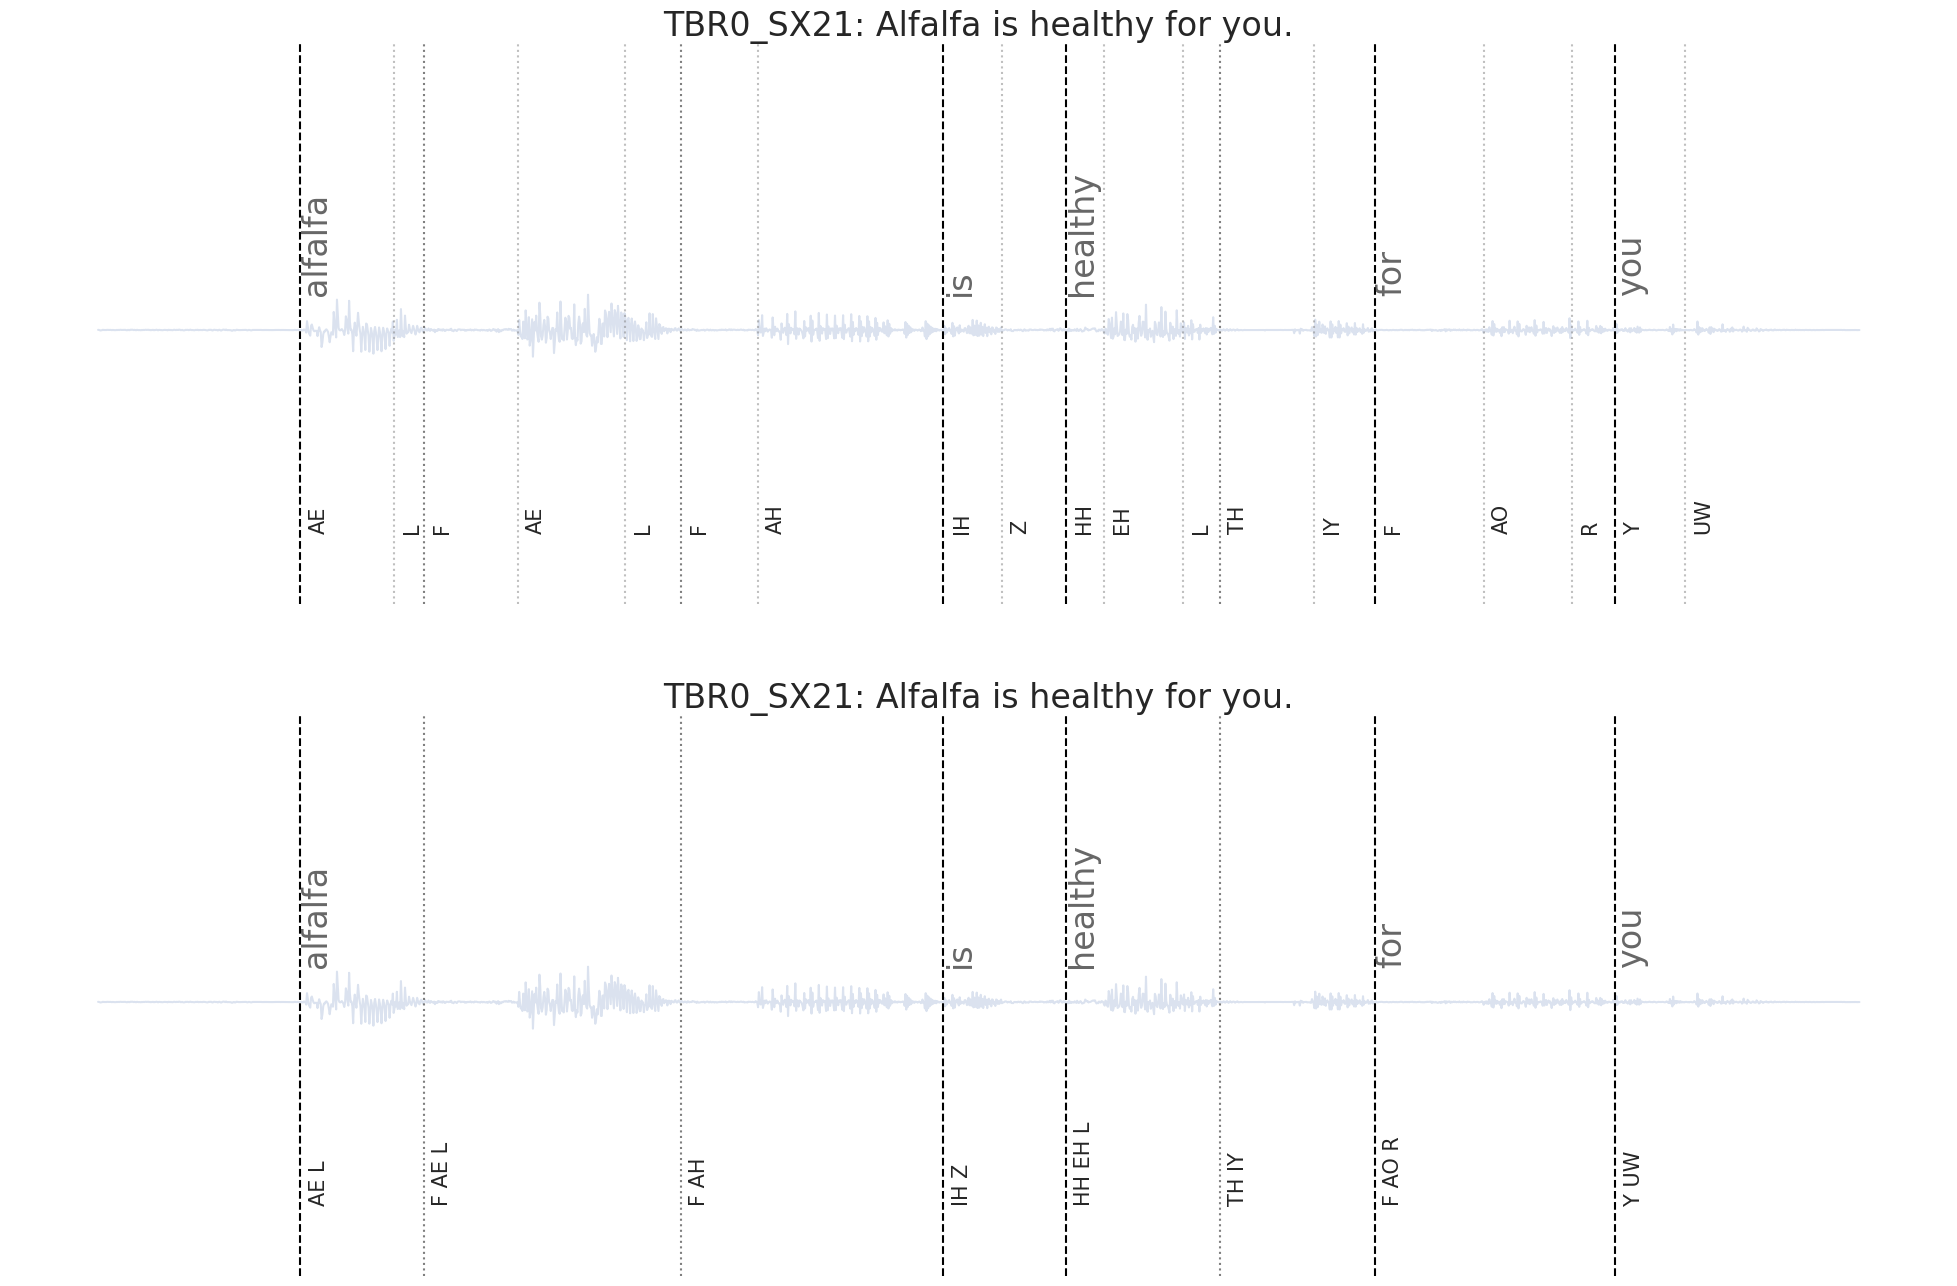

In [26]:
f, axs = plt.subplots(2, 1, figsize=(25, 2 * 8))
idx = np.random.choice(len(corpus))
print(idx)
plot_item(idx, axs[0], plot_units="phoneme")
plot_item(idx, axs[1], plot_units="syllable")

374


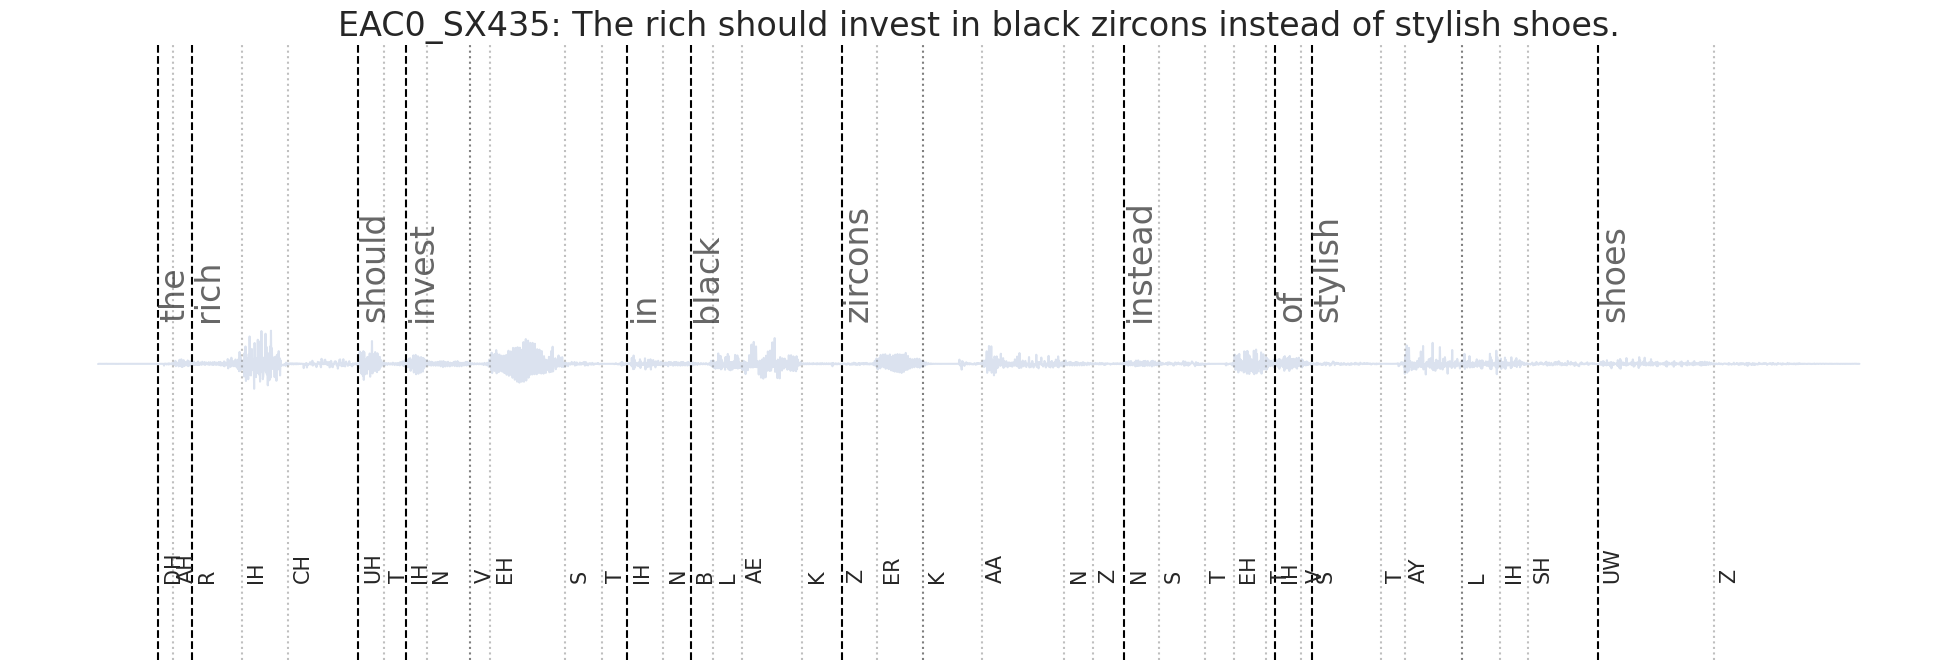

In [50]:
plot_idx = next(iter([idx for idx, original_idx in enumerate(corpus["original_idx"]) if original_idx == 468]))
print(plot_idx)
f, ax = plt.subplots(figsize=(25, 8))
plot_item(plot_idx, ax)

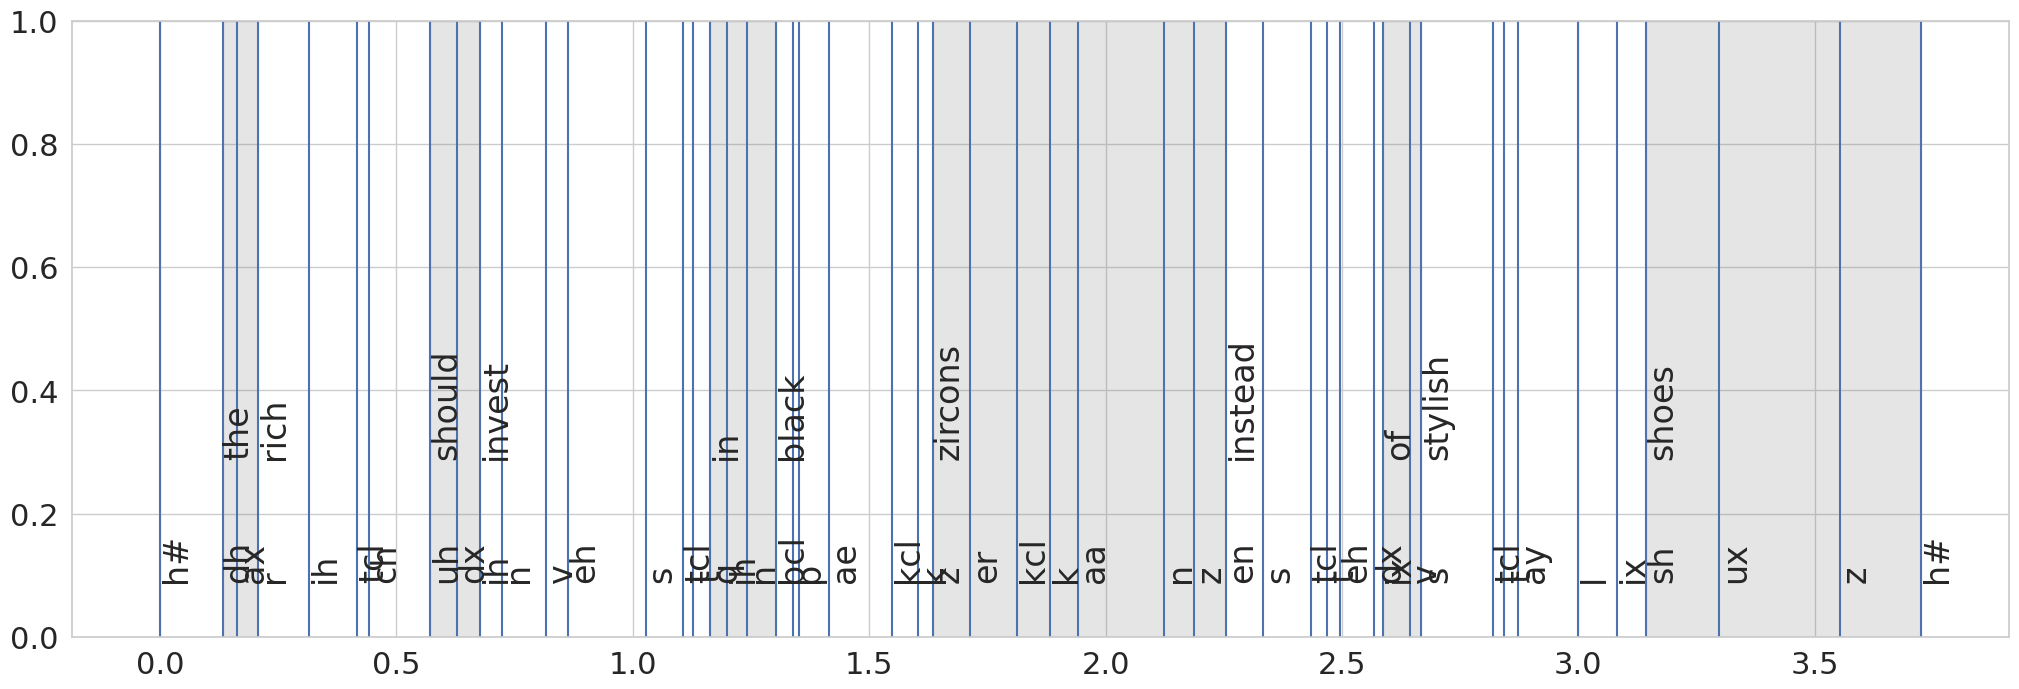

In [61]:
plot_raw_detail = raw_corpus["train"][468]
f, ax = plt.subplots(figsize=(25, 8))
for start, utt in zip(plot_raw_detail["phonetic_detail"]["start"], plot_raw_detail["phonetic_detail"]["utterance"]):
    ax.axvline(start / 16000)
    ax.text(start / 16000, 0.1, utt, rotation=90, horizontalalignment="left")

for i, (start, stop, utt) in enumerate(zip(plot_raw_detail["word_detail"]["start"], plot_raw_detail["word_detail"]["stop"], plot_raw_detail["word_detail"]["utterance"])):
    if i % 2 == 0:
        ax.axvspan(start / 16000, stop / 16000, alpha=0.2, color="gray")
    ax.text(start / 16000, 0.3, utt, rotation=90, horizontalalignment="left")

In [56]:
plot_raw_detail.keys()

dict_keys(['start', 'stop', 'utterance'])

## Check word-level correspondence with CMUdict

In [27]:
from tempfile import NamedTemporaryFile
from urllib.request import urlretrieve
import re

# Download and parse cmudict
cmudict_entries = defaultdict(list)
with NamedTemporaryFile() as f:
    urlretrieve("https://github.com/cmusphinx/cmudict/raw/master/cmudict.dict", f.name)

    with open(f.name, "r") as f:
        for line in f:
            # remove comments
            line = re.sub(r'(\s)*#.*', '', line)

            fields = line.strip().split(" ")
            word = fields[0]

            # remove word idx number, indicating secondary pronunciation
            word = re.sub(r"\(\d\)$", "", word)

            phones = tuple(fields[1:])
            # remove stress markers
            phones = tuple(re.sub(r"\d", "", p) for p in phones)

            cmudict_entries[word].append(phones)


In [28]:
# Track attested pronunciations of each word in TIMIT
corpus_cmudict_mapping = defaultdict(Counter)
def process_item(item):
    for word, word_phonemes in zip(item["word_detail"]["utterance"], item["word_phonemic_detail"]):
        corpus_cmudict_mapping[word][tuple(p["phone"] for p in word_phonemes)] += 1
corpus.map(process_item)

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 5040
})

In [29]:
# How many words have multiple pronunciations?
multiple_pronunciations = {k: v for k, v in corpus_cmudict_mapping.items() if len(v) > 1}
print(f"{len(multiple_pronunciations)} words ({len(multiple_pronunciations) / len(corpus_cmudict_mapping) * 100}%) have multiple pronunciations")

2132 words (34.950819672131146%) have multiple pronunciations


In [30]:
# How many words have CMUDICT pronunciations?
has_cmudict = {k: v for k, v in corpus_cmudict_mapping.items() if k in cmudict_entries}
print(f"{len(has_cmudict)} words ({len(has_cmudict) / len(corpus_cmudict_mapping) * 100}%) have CMUDICT pronunciations")

6068 words (99.47540983606558%) have CMUDICT pronunciations


In [31]:
# For how many words does the majority pronunciation align with the CMUDICT pronunciation?
majority_aligned = {k: v for k, v in corpus_cmudict_mapping.items()
                    if len(cmudict_entries[k]) > 0 and v.most_common(1)[0][0] == cmudict_entries[k][0]}
majority_misaligned = {k: v for k, v in corpus_cmudict_mapping.items()
                       if len(cmudict_entries[k]) > 0 and v.most_common(1)[0][0] != cmudict_entries[k][0]}
print(f"{len(majority_aligned)} words ({len(majority_aligned) / len(corpus_cmudict_mapping) * 100}%) have majority-aligned CMUDICT pronunciations")

2998 words (49.14754098360656%) have majority-aligned CMUDICT pronunciations


In [32]:
# For misaligned majorities, compare with CMUDICT
for word, counts in majority_misaligned.items():
    print(f"{word}: {' '.join(counts.most_common(1)[0][0])} (TIMIT) vs {' '.join(cmudict_entries[word][0])} (CMUDICT)")

step: S T IH P (TIMIT) vs S T EH P (CMUDICT)
forward: F OW W IH D (TIMIT) vs F AO R W ER D (CMUDICT)
could: K IH D (TIMIT) vs K UH D (CMUDICT)
or: ER (TIMIT) vs AO R (CMUDICT)
borrow: B AA R AH (TIMIT) vs B AA R OW (CMUDICT)
and: IH N (TIMIT) vs AH N D (CMUDICT)
bus: B AH TH (TIMIT) vs B AH S (CMUDICT)
sailboat: S EY L V OW T (TIMIT) vs S EY L B OW T (CMUDICT)
minute: M IH N IH T (TIMIT) vs M IH N AH T (CMUDICT)
becalmed: B AH K AA M (TIMIT) vs B IH K AA M D (CMUDICT)
had: HH AE T (TIMIT) vs HH AE D (CMUDICT)
permanent: P ER M IH N EH N (TIMIT) vs P ER M AH N AH N T (CMUDICT)
records: EH K ER D Z (TIMIT) vs R AH K AO R D Z (CMUDICT)
meeting: M IY T IY NG (TIMIT) vs M IY T IH NG (CMUDICT)
critical: K R IH T IH K L (TIMIT) vs K R IH T IH K AH L (CMUDICT)
equipment: IY K W IH P M IH N T (TIMIT) vs IH K W IH P M AH N T (CMUDICT)
maintenance: M EY T N IH N T S (TIMIT) vs M EY N T AH N AH N S (CMUDICT)
takes: T EY K (TIMIT) vs T EY K S (CMUDICT)
to: T IH (TIMIT) vs T UW (CMUDICT)
attributed:

In [33]:
majority_misaligned.get("success")

Counter({('IH', 'K', 'S', 'EH', 'S'): 5,
         ('AH', 'K', 'S', 'EH', 'S'): 2,
         ('S', 'IH', 'K', 'S', 'EH', 'S'): 2})

In [34]:
majority_misaligned.get("provoked")

Counter({('P', 'AH', 'V', 'OW', 'K', 'T'): 3,
         ('P', 'ER', 'V', 'OW', 'K', 'T'): 1,
         ('P', 'R', 'AH', 'V', 'OW', 'K', 'T'): 1,
         ('P', 'R', 'ER', 'V', 'OW', 'K', 'T'): 1,
         ('P', 'R', 'AH', 'V', 'OW', 'T'): 1})

In [35]:
# matches = [idx for idx in trange(len(corpus)) if "success" in corpus[idx]["word_detail"]["utterance"]]
# matches

## Syllable analysis

In [36]:
all_syllable_counts = Counter()
word_syllable_counts = defaultdict(Counter)

def process_item(item):
    for i, (word, syllables) in enumerate(zip(item["word_detail"]["utterance"], item["word_syllable_detail"])):
        syll_string = tuple(tuple(syllable["phones"]) for syllable in syllables)
        word_syllable_counts[word][syll_string] += 1
        for syllable in syll_string:
            all_syllable_counts[syllable] += 1
corpus.map(process_item)

Map:   0%|          | 0/5040 [00:00<?, ? examples/s]

Dataset({
    features: ['file', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id', 'word_phonetic_detail', 'input_values', 'phone_targets', 'original_idx', 'original_split', 'idx', 'phonemic_detail', 'word_phonemic_detail', 'word_syllable_detail'],
    num_rows: 5040
})

In [37]:
all_syllable_counts.most_common(20)

[(('AH',), 1494),
 (('IH', 'N'), 1217),
 (('IH',), 1188),
 (('DH', 'AH'), 895),
 (('ER',), 885),
 (('DH', 'IH'), 789),
 (('IH', 'Z'), 602),
 (('L', 'IY'), 589),
 (('T', 'IH'), 560),
 (('T', 'ER'), 452),
 (('D', 'IH'), 441),
 (('T', 'IY'), 422),
 (('AH', 'V'), 414),
 (('R', 'IY'), 402),
 (('IY',), 372),
 (('B', 'IY'), 363),
 (('T', 'UW'), 340),
 (('P', 'ER'), 337),
 (('EY',), 334),
 (('Y', 'UW'), 324)]

In [38]:
cmudict_vowels = {"AA", "AE", "AH", "AO", "AW", "AY", "EH", "ER", "EY", "IH", "IY", "OW", "OY", "UH", "UW"}

print("Syllabic consonant frequencies:")
syllabic_frequencies = Counter({k: v for k, v in all_syllable_counts.items() if len(k) == 1 and k[0] not in cmudict_vowels})
pprint(syllabic_frequencies)

print("Proportion of total syllable tokens: ", sum(syllabic_frequencies.values()) / sum(all_syllable_counts.values()) * 100, "%")

Syllabic consonant frequencies:
Counter({('N',): 120,
         ('DH',): 24,
         ('T',): 17,
         ('F',): 16,
         ('V',): 12,
         ('Z',): 10,
         ('L',): 6,
         ('M',): 6,
         ('D',): 6,
         ('S',): 5,
         ('JH',): 2,
         ('Y',): 2,
         ('NG',): 2,
         ('HH',): 2,
         ('R',): 1,
         ('TH',): 1,
         ('CH',): 1,
         ('ZH',): 1})
Proportion of total syllable tokens:  0.3740409207161125 %


In [39]:
multiple_syllabification_words = Counter({k: v for k, v in word_syllable_counts.items() if len(v) > 1})
print(f"{len(multiple_syllabification_words)} words ({len(multiple_syllabification_words) / len(word_syllable_counts) * 100}%) have multiple syllabifications")

2132 words (34.950819672131146%) have multiple syllabifications


In [40]:
# Log top token frequency syllables
sorted(multiple_syllabification_words.items(), key=lambda x: sum(x[1].values()), reverse=True)[:10]

[('the',
  Counter({(('DH', 'AH'),): 882,
           (('DH', 'IH'),): 754,
           (('DH', 'IY'),): 291,
           (('AH',),): 81,
           (('IH',),): 60,
           (('IY',),): 32,
           (('DH',),): 24,
           (('DH', 'ER'),): 14,
           (('DH', 'EH'),): 11,
           (('D', 'IH'),): 7,
           (('TH', 'AH'),): 6,
           (('N', 'IH'),): 4,
           (('DH', 'L'),): 3,
           (('DH', 'AA'),): 3,
           (('DH', 'UH'),): 3,
           (('TH', 'IH'),): 3,
           (('S',),): 2,
           (('N', 'IY'),): 2,
           (('T', 'IH'),): 2,
           (('Z', 'AH'),): 2,
           (('S', 'AH'),): 1,
           (('D', 'IY'),): 1,
           (('T',),): 1,
           (('AH',), ('Z', 'AH')): 1,
           (('N', 'AH'),): 1,
           (('Z', 'DH', 'IH'),): 1,
           (('D', 'AH'),): 1,
           (('DH', 'T', 'EH'),): 1,
           (('D', 'DH', 'IH'),): 1,
           (('TH',),): 1,
           (('DH', 'AE'),): 1,
           (('AH',), ('DH', 'AH')): 1,
    

In [41]:
# Syllables without any content
# This can emerge when, according to TIMIT annotation, a syllable is completely coarticulated
# with its preceding syllable. We arbitrarily assign phoneme annotations to the preceding syllable,
# leaving the latter syllable empty.
empty_syllables = {word: counts[()] for word, counts in word_syllable_counts.items()
                   if () in counts and counts[()] > 0}
print(f"{len(empty_syllables)} syllables ({sum(empty_syllables.values())} tokens, {sum(empty_syllables.values()) / sum(all_syllable_counts.values()) * 100}%) are empty")

8 syllables (28 tokens, 0.04475703324808184%) are empty


## Save to disk

In [42]:
corpus.save_to_disk(out_path)

Saving the dataset (0/3 shards):   0%|          | 0/5040 [00:00<?, ? examples/s]